In [113]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [114]:
# '围网', '拖网', '刺网'

In [115]:
type_dict = {'围网':'wei','拖网':'tuo','刺网':'ci'}

In [116]:
train = pd.read_hdf('E:/Msstudy/tianchi/smart_sea_active/input/train.h5')

In [117]:
test = pd.read_hdf('E:/Msstudy/tianchi/smart_sea_active/input/test.h5')

In [118]:
train.describe()

ship             x             y             v             d
count  2.699638e+06  2.699638e+06  2.699638e+06  2.699638e+06  2.699638e+06
mean   3.496035e+03  6.277243e+06  5.271190e+06  1.784449e+00  1.151533e+02
std    2.020781e+03  2.698065e+05  2.544160e+05  2.478862e+00  1.168515e+02
min    0.000000e+00  5.000250e+06  3.345433e+06  0.000000e+00  0.000000e+00
25%    1.739000e+03  6.118054e+06  5.114766e+06  1.100000e-01  0.000000e+00
50%    3.502000e+03  6.246522e+06  5.229463e+06  3.200000e-01  8.100000e+01
75%    5.243000e+03  6.365916e+06  5.379267e+06  3.290000e+00  2.170000e+02
max    6.999000e+03  7.133785e+06  7.667581e+06  1.001600e+02  3.600000e+02

In [119]:
def data_preprocess(data):
    df=data.copy()
    df['x_move']=df['x']-df.groupby('ship')['x'].shift(-1)
    df['y_move']=df['y']-df.groupby('ship')['y'].shift(-1)
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    df['time_diff']=df['time']-df.groupby('ship')['time'].shift(-1)
    df['second_diff']=df['time_diff'].dt.seconds
    df=df.dropna()
    df=df[(df['v']!=0) & (df['v']<=15)]
    df=df[(df['second_diff']>=300)& (df['second_diff']<=2400)]
    print(df.columns)
    return df



In [122]:
data=data_preprocess(train)
#train_label=data.drop_duplicates('ship')
#train_label['ship'].count()
data

Index(['ship', 'x', 'y', 'v', 'd', 'time', 'type', 'x_move', 'y_move',
       'time_diff', 'second_diff'],
      dtype='object')


ship             x             y      v    d                time type  \
0       0  6.152038e+06  5.124873e+06   2.59  102 1900-11-10 11:58:19   拖网   
1       0  6.151230e+06  5.125218e+06   2.70  113 1900-11-10 11:48:19   拖网   
2       0  6.150421e+06  5.125563e+06   2.70  116 1900-11-10 11:38:19   拖网   
3       0  6.149612e+06  5.125907e+06   3.29   95 1900-11-10 11:28:19   拖网   
4       0  6.148803e+06  5.126252e+06   3.18  108 1900-11-10 11:18:19   拖网   
5       0  6.147998e+06  5.126815e+06   2.97  129 1900-11-10 11:08:19   拖网   
6       0  6.147191e+06  5.127269e+06   3.29  116 1900-11-10 10:58:19   拖网   
7       0  6.146279e+06  5.127508e+06   3.56  102 1900-11-10 10:48:19   拖网   
8       0  6.145365e+06  5.127637e+06   1.19  108 1900-11-10 10:38:19   拖网   
9       0  6.143829e+06  5.127017e+06   7.99   93 1900-11-10 10:28:19   拖网   
10      0  6.141387e+06  5.127072e+06   8.09   90 1900-11-10 10:18:19   拖网   
11      0  6.139046e+06  5.127016e+06   8.36   84 1900-11-10 10:09:17   拖网   
12      0  6.136294e+06  5.126752e+06   8.36   81 1900-11-10 09:58:19   拖网   
13      0  6.133849e+06  5.126590e+06   8.26   84 1900-11-10 09:48:19   拖网   
14      0  6.131202e+06  5.126543e+06   8.15   92 1900-11-10 09:38:19   拖网   
15      0  6.128554e+06  5.126388e+06   9.39   83 1900-11-10 09:28:19   拖网   
16      0  6.125911e+06  5.126561e+06   7.88   96 1900-11-10 09:18:20   拖网   
17      0  6.123485e+06  5.127492e+06   8.74  105 1900-11-10 09:09:53   拖网   
18      0  6.119668e+06  5.130312e+06   6.58  113 1900-11-10 08:48:20   拖网   
19      0  6.118455e+06  5.130779e+06   0.27    0 1900-11-10 08:38:19   拖网   
22      0  6.118352e+06  5.130672e+06   0.05    0 1900-11-10 08:09:17   拖网   
56      0  6.118352e+06  5.130672e+06   0.05    0 1900-11-10 01:58:21   拖网   
57      0  6.118352e+06  5.130672e+06   0.27    0 1900-11-10 01:48:21   拖网   
58      0  6.118352e+06  5.130672e+06   0.05    0 1900-11-10 01:38:21   拖网   
68      0  6.118354e+06  5.130781e+06   0.27    0 1900-11-09 23:59:52   拖网   
71      0  6.118352e+06  5.130672e+06   0.05    0 1900-11-09 23:18:21   拖网   
81      0  6.118352e+06  5.130672e+06   0.05    0 1900-11-09 21:28:21   拖网   
109     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-09 16:48:22   拖网   
128     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-09 13:38:23   拖网   
152     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-09 09:28:23   拖网   
197     0  6.118352e+06  5.130672e+06   0.16    0 1900-11-09 01:58:24   拖网   
198     0  6.118352e+06  5.130672e+06   0.49    0 1900-11-09 01:49:55   拖网   
200     0  6.118352e+06  5.130672e+06   0.27    0 1900-11-09 01:18:24   拖网   
245     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 17:18:26   拖网   
249     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 16:38:25   拖网   
256     0  6.118352e+06  5.130672e+06   0.16    0 1900-11-08 15:28:27   拖网   
258     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 15:08:27   拖网   
289     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 09:58:28   拖网   
292     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 09:28:27   拖网   
313     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 05:50:00   拖网   
314     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 05:28:28   拖网   
335     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 01:58:28   拖网   
336     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-08 01:48:28   拖网   
403     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-07 13:58:30   拖网   
404     0  6.118352e+06  5.130672e+06   0.05    0 1900-11-07 13:48:30   拖网   
0       1  6.076254e+06  5.061743e+06   3.99  278 1900-11-10 11:40:21   拖网   
1       1  6.077380e+06  5.061819e+06   4.26  257 1900-11-10 11:33:03   拖网   
2       1  6.079838e+06  5.062075e+06   3.67  257 1900-11-10 11:10:22   拖网   
3       1  6.081068e+06  5.062258e+06   3.78  256 1900-11-10 11:00:22   拖网   
4       1  6.082194e+06  5.062335e+06   3.99  251 1900-11-10 10:50:22   拖网   
5       1  6.083422e+06  5.

In [129]:
count_ship=data.groupby('ship')['ship'].count()
count_ship

count_ship[count_ship.values<10]

ship
254     4
2318    9
2739    3
3554    6
4650    4
4872    2
5034    3
5464    2
Name: ship, dtype: int64

In [124]:
data.describe()

ship             x             y             v             d  \
count  2.081608e+06  2.081608e+06  2.081608e+06  2.081608e+06  2.081608e+06   
mean   3.495947e+03  6.290512e+06  5.274583e+06  2.244107e+00  1.314819e+02   
std    2.018833e+03  2.835268e+05  2.607993e+05  2.550153e+00  1.155321e+02   
min    0.000000e+00  5.000250e+06  3.731423e+06  5.000000e-02  0.000000e+00   
25%    1.751000e+03  6.138314e+06  5.114873e+06  2.200000e-01  1.000000e+01   
50%    3.495000e+03  6.246626e+06  5.234734e+06  1.080000e+00  1.100000e+02   
75%    5.241000e+03  6.393180e+06  5.409303e+06  3.720000e+00  2.310000e+02   
max    6.999000e+03  7.133785e+06  7.667581e+06  1.479000e+01  3.600000e+02   

             x_move        y_move               time_diff   second_diff  
count  2.081608e+06  2.081608e+06                 2081608  2.081608e+06  
mean  -5.656697e+00 -7.494525e+00  0 days 00:10:58.117609  6.581176e+02  
std    4.722978e+03  4.829965e+03  0 days 00:03:31.389243  2.113892e+02  
min   -2.018556e+06 -2.302553e+06         0 days 00:05:00  3.000000e+02  
25%   -1.004445e+02 -1.089652e+02         0 days 00:09:59  5.990000e+02  
50%    0.000000e+00  0.000000e+00         0 days 00:10:00  6.000000e+02  
75%    9.889726e+01  9.670893e+01         0 days 00:10:03  6.030000e+02  
max    2.015933e+06  2.301035e+06         0 days 00:40:00  2.400000e+03

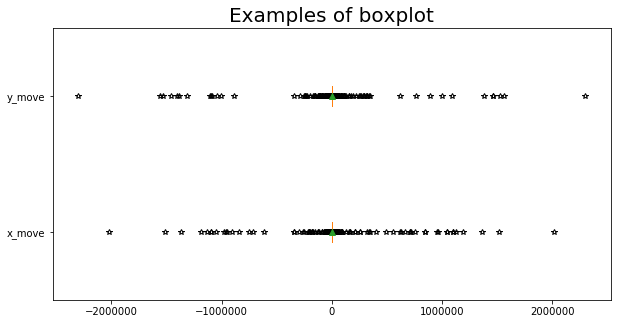

In [125]:
import matplotlib.pyplot as plt
 
box_1, box_2= data['x_move'], data['y_move']
 
plt.figure(figsize=(10,5))#设置画布的尺寸
plt.title('Examples of boxplot',fontsize=20)#标题，并设定字号大小
labels = 'x_move','y_move'#图例
plt.boxplot([box_1, box_2], labels = labels,sym = '*',vert=False,showmeans=True,patch_artist = True, boxprops = {'color':'orangered','facecolor':'pink'} )#grid=False：代表不显示背景中的网格线
# data.boxplot()#画箱型图的另一种方法，参数较少，而且只接受dataframe，不常用
plt.show()


In [126]:
data[data['x_move']>10000]

ship             x             y      v    d                time type  \
288  1068  6.667448e+06  5.587681e+06   0.22  269 1900-11-11 18:32:10   围网   
375  1093  6.573466e+06  5.699857e+06   8.31  352 1900-11-04 02:12:01   刺网   
157  1101  6.305832e+06  5.251429e+06   7.72  360 1900-11-22 17:45:32   拖网   
75   1220  6.253173e+06  5.251032e+06   0.11   50 1900-10-30 06:12:59   刺网   
148  1236  6.306863e+06  5.234897e+06   0.32  360 1900-11-11 08:56:13   刺网   
64   1253  6.691786e+06  5.736795e+06   4.10  189 1900-11-06 10:14:14   围网   
15    127  6.180138e+06  5.192647e+06   0.11  360 1900-11-20 20:52:52   刺网   
33    127  6.180138e+06  5.192647e+06   0.22  360 1900-11-20 17:21:55   刺网   
39    127  6.180138e+06  5.192647e+06   0.22  360 1900-11-20 15:21:54   刺网   
50    127  6.180138e+06  5.192647e+06   0.22  360 1900-11-20 12:51:26   刺网   
53    127  6.180138e+06  5.192647e+06   0.22  360 1900-11-20 11:51:22   刺网   
63    127  6.180138e+06  5.192647e+06   0.22  360 1900-11-20 08:21:19   刺网   
73    127  6.180138e+06  5.192647e+06   2.70  360 1900-11-20 05:20:13   刺网   
92    127  6.180138e+06  5.192647e+06   0.11  360 1900-11-19 23:49:51   刺网   
121   127  6.180138e+06  5.192647e+06   1.89  360 1900-11-19 12:47:41   刺网   
132   127  6.180138e+06  5.192647e+06   0.32  360 1900-11-19 07:47:41   刺网   
142   127  6.180138e+06  5.192647e+06   0.32  360 1900-11-19 03:16:30   刺网   
149   127  6.180138e+06  5.192647e+06   0.32  360 1900-11-19 00:46:22   刺网   
176   127  6.180138e+06  5.192647e+06   0.32  360 1900-11-18 12:14:14   刺网   
183   127  6.180138e+06  5.192647e+06   0.32  360 1900-11-18 09:44:39   刺网   
191   127  6.180138e+06  5.192647e+06   0.32  360 1900-11-18 06:44:03   刺网   
203   127  6.180138e+06  5.192647e+06   0.22  360 1900-11-18 03:43:05   刺网   
17   1284  6.417630e+06  5.329569e+06   2.70  186 1900-11-10 09:08:47   拖网   
70   1284  6.380836e+06  5.314330e+06   8.58   91 1900-11-10 00:09:10   拖网   
328  1305  6.899886e+06  5.566778e+06   0.22  292 1900-11-04 09:30:05   围网   
169  1310  6.377924e+06  5.316411e+06   6.69   50 1900-11-22 17:54:21   拖网   
29   1371  6.383045e+06  5.421833e+06   0.22  360 1900-10-30 15:40:56   拖网   
34   1371  6.383045e+06  5.421833e+06   0.22  360 1900-10-30 13:40:54   拖网   
38   1371  6.383045e+06  5.421833e+06   0.11  360 1900-10-30 12:10:32   拖网   
40   1371  6.383045e+06  5.421833e+06   0.11  360 1900-10-30 11:10:40   拖网   
313  1396  6.148394e+06  5.126152e+06   3.08  205 1900-10-28 16:41:59   拖网   
132   145  6.431080e+06  5.391781e+06   9.01   91 1900-11-22 20:51:08   围网   
140  1458  6.450314e+06  5.459764e+06   9.39   91 1900-11-09 11:43:55   围网   
284  1547  5.905571e+06  5.005022e+06   7.99   71 1900-11-08 10:37:27   拖网   
324  1651  6.252661e+06  5.250162e+06   0.22   71 1900-11-04 06:50:57   刺网   
208  1666  6.550279e+06  5.403323e+06   5.72   40 1900-10-29 07:19:12   围网   
132  1744  6.690193e+06  5.672027e+06   9.61  105 1900-11-20 01:08:58   围网   
152  1744  6.643849e+06  5.689635e+06   8.90  125 1900-11-19 21:50:21   围网   
22   1750  6.408364e+06  5.343465e+06   3.08   10 1900-11-17 08:15:09   围网   
96   1781  6.180238e+06  5.192536e+06   0.11    0 1900-10-30 06:28:15   拖网   
118  1908  6.623233e+06  5.555770e+06   4.59  206 1900-11-16 14:18:14   拖网   
166  1916  6.246147e+06  5.221901e+06   7.39  122 1900-11-05 13:59:15   拖网   
125  1941  7.016183e+06  6.085784e+06   0.70  342 1900-11-12 22:21:44   围网   
81   1985  6.418051e+06  5.406437e+06   8.69   91 1900-11-09 21:21:26   围网   
23   1990  6.541450e+06  5.579495e+06   7.18   91 1900-11-20 19:39:30   拖网   
17    222  6.304954e+06  5.236988e+06   0.32  360 1900-11-23 10:38:24   刺网   
179  2260  7.047289e+06  6.114043e+06   0.32  290 1900-11-09 04:28:21   围网   
76   2328  6.385457e+06  5.402599e+06   8.09  108 1900-11-09 22:17:44   拖网   
10    243  6.180138e+06  5.192647e+06   0.32  360 1900-11-23 19:04:20   刺网   
28    243  6.180138e+06  5.192647e+06   0.32  360 1900-11-23 15:33:25   刺网   
47    243  6.180138e+06  5.

In [120]:
test_data=data_preprocess(test)
test_ship=test_data.groupby('ship')['ship'].count()
test_ship

Index(['ship', 'x', 'y', 'v', 'd', 'time', 'x_move', 'y_move', 'time_diff',
       'second_diff'],
      dtype='object')


ship
7000    327
7001    394
7002    402
7003    336
7004    310
7005    268
7006    302
7007    307
7008    404
7009    416
7010    410
7011    268
7012    183
7013    419
7014    293
7015    289
7016    318
7017    395
7018    319
7019    407
7020    353
7021    399
7022    339
7023    358
7024    269
7025    341
7026    310
7027    331
7028    356
7029     95
7030    283
7031    389
7032    280
7033     59
7034    211
7035    236
7036    302
7037    381
7038    306
7039    301
7040    303
7041    422
7042    305
7043    266
7044    379
7045    295
7046    377
7047    365
7048    374
7049    354
7050    401
7051    381
7052    308
7053    285
7054    293
7055    200
7056    305
7057    406
7058    379
7059    271
7060    315
7061    408
7062    341
7063    381
7064    321
7065    339
7066    415
7067    388
7068    290
7069    363
7070    398
7071    336
7072    231
7073     50
7074    359
7075    359
7076    370
7077    357
7078    290
7079    382
7080    305
7081    376
7082    394

In [121]:
count_ship_test=test_data.groupby('ship')['ship'].count()
count_ship_test

count_ship_test[count_ship_test.values<10]

ship
7225    7
7233    9
7524    4
8158    4
8619    9
8791    1
8808    7
Name: ship, dtype: int64

In [127]:
test_data.describe()

ship             x             y              v  \
count  607564.000000  6.075640e+05  6.075640e+05  607564.000000   
mean     7996.849074  6.288465e+06  5.280267e+06       2.270742   
std       576.513780  2.769736e+05  2.746752e+05       2.562576   
min      7000.000000  5.025842e+06  3.426329e+06       0.050000   
25%      7499.000000  6.141496e+06  5.114766e+06       0.220000   
50%      8001.000000  6.246624e+06  5.240931e+06       1.080000   
75%      8492.000000  6.404660e+06  5.412374e+06       3.780000   
max      8999.000000  7.123877e+06  6.793661e+06      13.980000   

                   d        x_move        y_move               time_diff  \
count  607564.000000  6.075640e+05  6.075640e+05                  607564   
mean      131.822582 -1.198939e+00 -7.943471e+00  0 days 00:10:57.638263   
std       114.835937  5.690769e+03  5.730018e+03  0 days 00:03:30.191090   
min         0.000000 -1.409677e+06 -1.764289e+06         0 days 00:05:00   
25%        10.000000 -1.009356e+02 -1.092879e+02         0 days 00:09:59   
50%       111.000000  0.000000e+00  0.000000e+00         0 days 00:10:00   
75%       231.000000  1.000869e+02  1.006284e+02         0 days 00:10:03   
max       360.000000  1.409084e+06  1.760507e+06         0 days 00:40:00   

         second_diff  
count  607564.000000  
mean      657.638264  
std       210.191091  
min       300.000000  
25%       599.000000  
50%       600.000000  
75%       603.000000  
max      2400.000000

In [128]:
test_data[test_data['x_move']>10000]

ship             x             y      v    d                time  \
172  7015  6.379655e+06  5.277613e+06   6.91   50 1900-11-22 16:12:52   
73   7024  6.345886e+06  5.308655e+06   0.11  134 1900-11-23 11:24:13   
2    7036  6.418141e+06  5.326719e+06   2.37   20 1900-11-10 11:32:48   
15   7036  6.407720e+06  5.322946e+06   9.50  117 1900-11-10 09:22:52   
79   7036  6.373005e+06  5.314435e+06   8.58  105 1900-11-09 22:31:55   
302  7053  6.158749e+06  5.198210e+06   0.32   20 1900-11-01 06:48:39   
274  7067  6.434926e+06  5.340417e+06   3.02    5 1900-11-11 21:48:13   
196  7090  6.169822e+06  5.179735e+06   0.32  354 1900-11-22 12:50:48   
66   7131  6.243609e+06  5.198862e+06   0.32  360 1900-11-02 08:31:28   
66   7133  6.813356e+06  5.678951e+06   9.39   77 1900-11-13 02:49:06   
71   7133  6.787329e+06  5.673930e+06   9.77   81 1900-11-13 01:18:57   
111  7133  6.640856e+06  5.646660e+06   8.58   80 1900-11-12 16:48:58   
277  7191  6.183190e+06  5.193574e+06   0.22  234 1900-11-21 19:55:45   
29   7203  6.320382e+06  5.175789e+06   0.38  341 1900-11-10 06:58:14   
33   7203  6.320877e+06  5.172291e+06   3.89  320 1900-11-10 06:28:11   
78   7231  6.364123e+06  5.414462e+06   0.22  141 1900-10-30 10:19:33   
210  7272  6.503938e+06  5.410731e+06   3.40   30 1900-11-16 00:03:11   
265  7294  6.461238e+06  5.472846e+06   0.11   20 1900-11-01 08:21:47   
126  7462  6.562939e+06  5.689360e+06  10.09  156 1900-10-29 23:41:54   
369  7501  6.377282e+06  5.396437e+06   4.21  180 1900-10-28 10:59:22   
109  7685  6.243609e+06  5.198862e+06   0.11  360 1900-11-04 13:07:46   
115  7685  6.243609e+06  5.198862e+06   0.32  360 1900-11-04 11:37:28   
118  7685  6.243609e+06  5.198862e+06   0.32  360 1900-11-04 11:07:08   
145  7685  6.243609e+06  5.198862e+06   0.32  360 1900-11-04 01:05:39   
9    7688  5.977708e+06  4.918916e+06   9.39  334 1900-11-17 09:51:37   
149  7750  6.180135e+06  5.192429e+06   0.32  360 1900-10-29 02:28:06   
170  7753  6.792788e+06  5.575383e+06   7.88  266 1900-10-29 15:08:51   
181  7822  6.403785e+06  5.410447e+06   7.02   71 1900-11-02 00:32:36   
192  7822  6.384253e+06  5.409192e+06   6.42   71 1900-11-01 23:02:30   
117  7873  6.381738e+06  5.316963e+06   3.78  208 1900-11-23 02:37:26   
341  7883  5.401899e+06  4.596361e+06   3.89  360 1900-11-11 11:29:42   
253  7884  6.201571e+06  5.164192e+06   0.22  116 1900-11-05 00:20:23   
55   7897  6.421202e+06  5.365475e+06   3.62   71 1900-11-23 13:31:55   
245  7959  7.077129e+06  5.952319e+06   0.11    0 1900-10-29 01:39:31   
272  8042  6.573271e+06  5.586831e+06   9.01  103 1900-11-15 11:33:26   
77   8063  6.457719e+06  5.378245e+06   1.62   30 1900-11-13 09:08:55   
152  8073  6.388260e+06  5.319384e+06   2.21  357 1900-11-22 20:02:13   
169  8073  6.365573e+06  5.309721e+06   8.47  100 1900-11-22 17:12:13   
123  8093  6.168016e+06  5.138940e+06   0.11  152 1900-11-02 14:02:34   
247  8125  6.322891e+06  5.167913e+06   3.08  339 1900-11-01 13:46:34   
221  8202  6.267690e+06  5.249887e+06   7.77  102 1900-11-22 07:03:12   
141  8274  6.382578e+06  5.154050e+06   5.02  204 1900-10-29 14:58:55   
178  8311  6.501038e+06  5.411682e+06   3.72  159 1900-10-29 14:10:19   
72   8335  6.313373e+06  5.269449e+06   0.11  274 1900-11-20 11:05:45   
17   8354  6.235593e+06  5.186836e+06   3.80  360 1900-10-30 20:52:08   
23   8354  6.241129e+06  5.193538e+06   2.10  248 1900-10-30 19:42:02   
25   8354  6.255934e+06  5.195435e+06   2.10  248 1900-10-30 19:22:14   
44   8433  6.246626e+06  5.241150e+06   0.11    0 1900-11-06 14:10:10   
307  8482  6.525247e+06  5.623604e+06   0.22  324 1900-10-28 11:23:10   
92   8546  6.926965e+06  5.467687e+06   6.31  202 1900-11-16 19:32:40   
64   8659  6.180135e+06  5.192429e+06   0.22  360 1900-11-20 13:11:27   
396  8732  6.487861e+06  5.414267e+06   3.89   50 1900-11-11 01:15:37   
69   8796  6.180341e+06  5.192643e+06   0.22   50 1900-10-30 11:06:19   
1    8856  5.786381e+06  4.919675e+06   0.59  182 1900-11-06 23

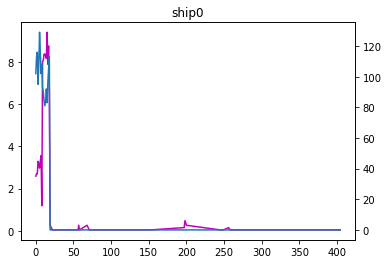

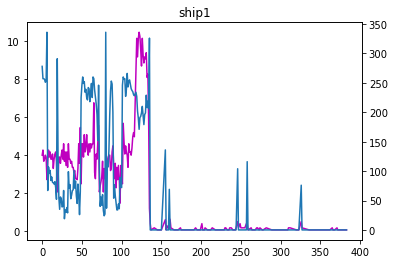

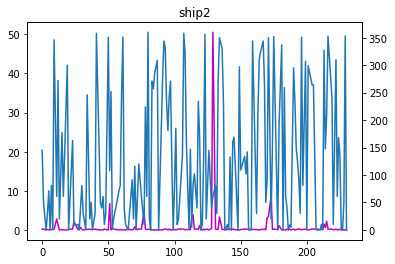

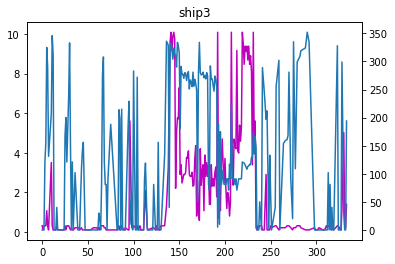

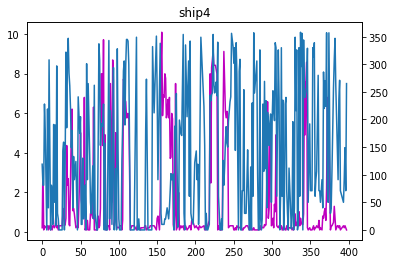

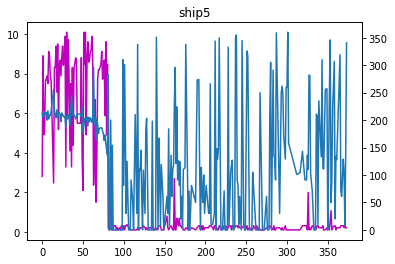

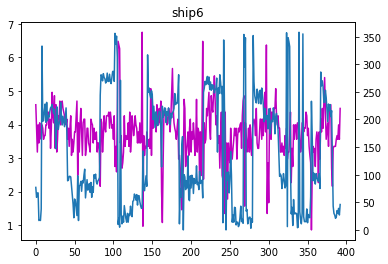

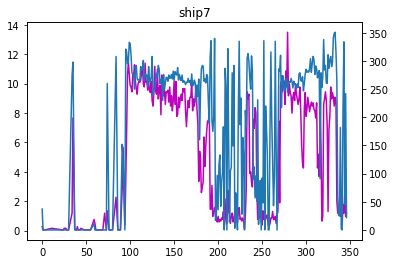

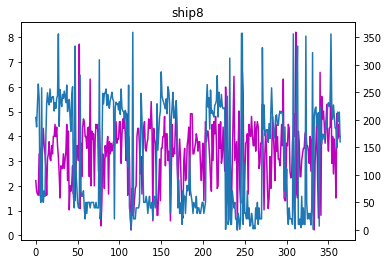

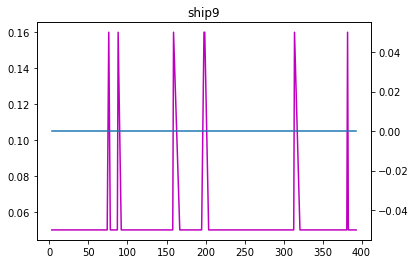

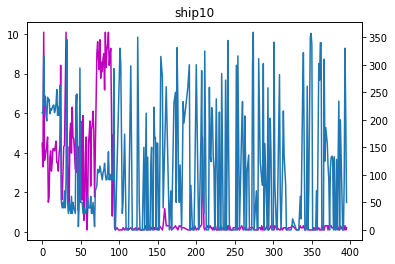

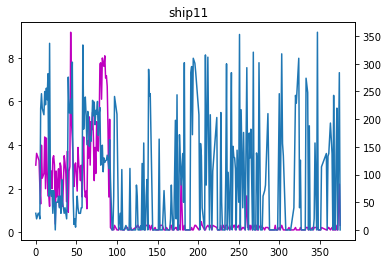

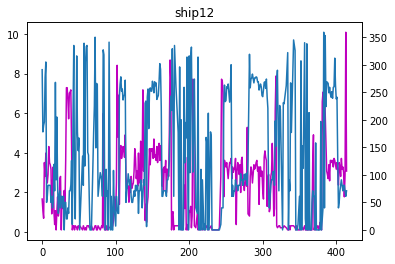

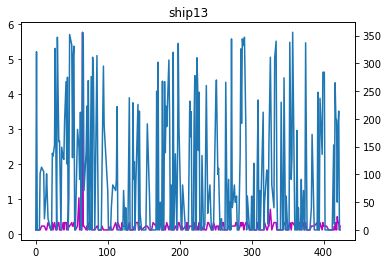

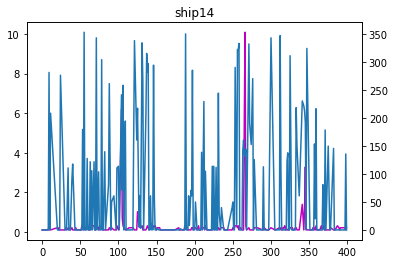

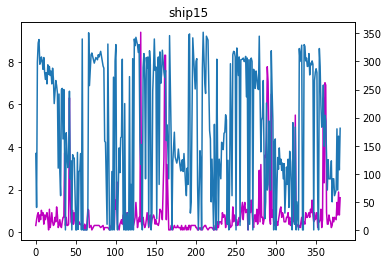

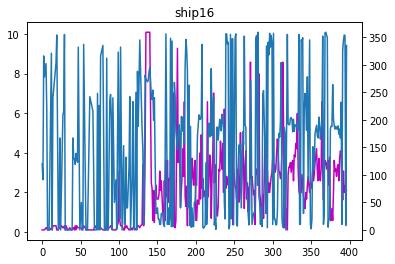

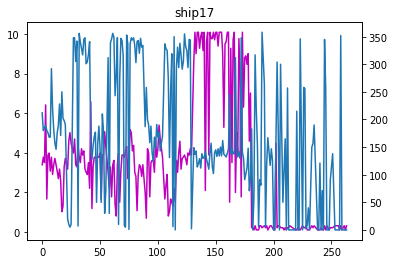

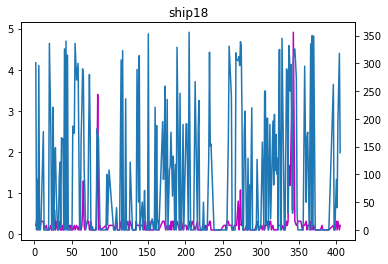

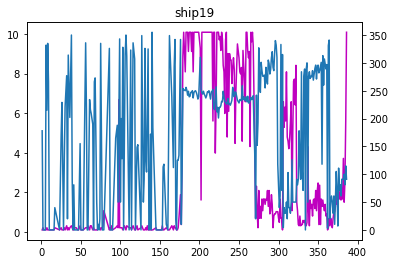

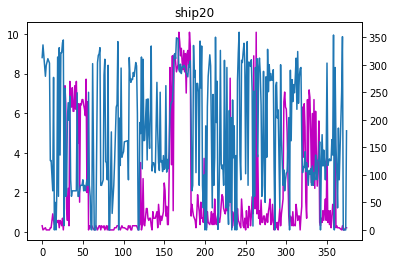

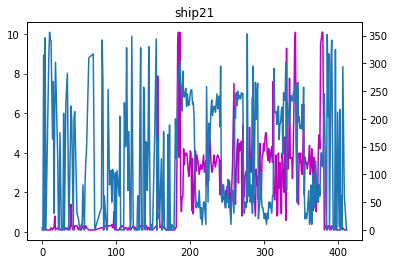

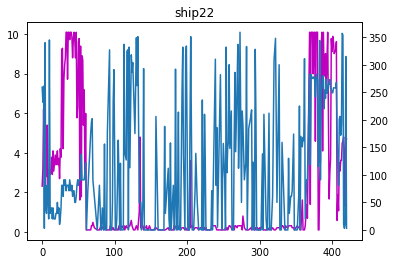

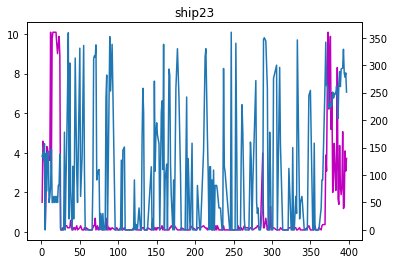

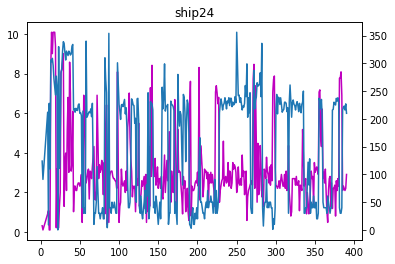

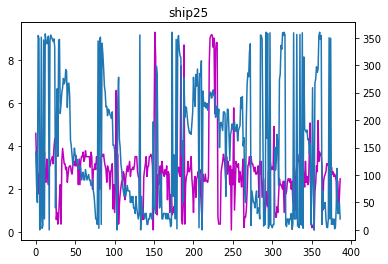

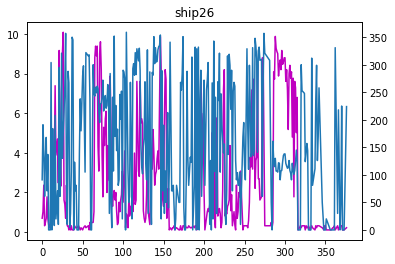

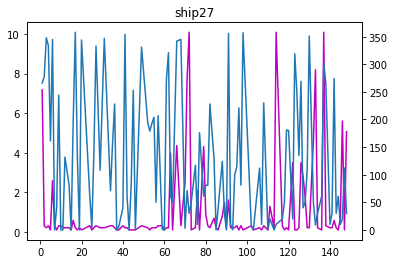

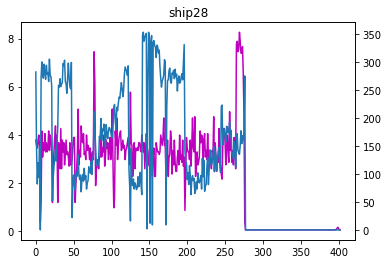

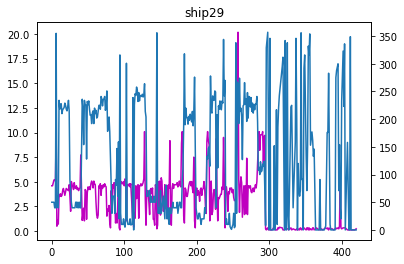

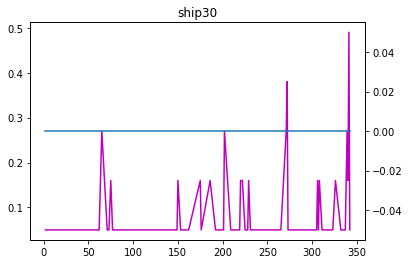

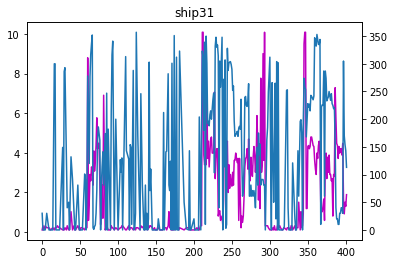

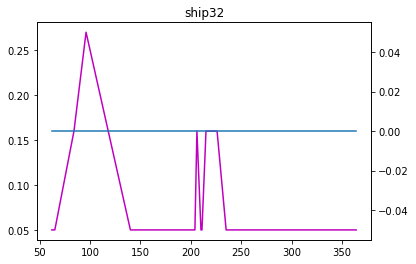

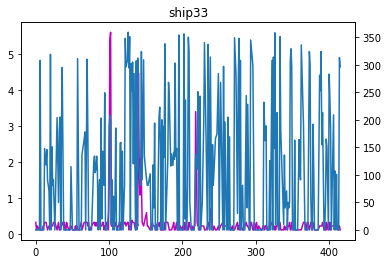

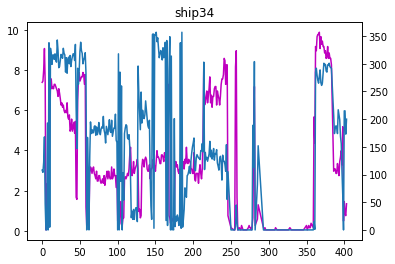

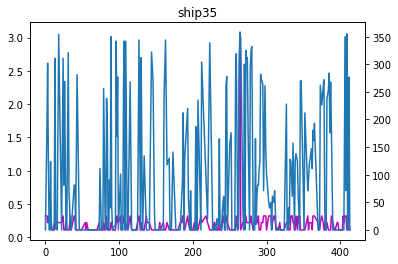

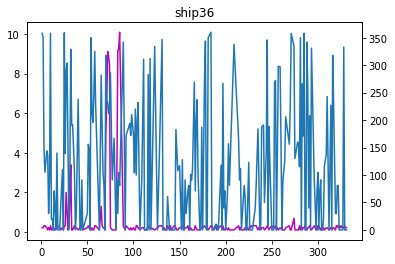

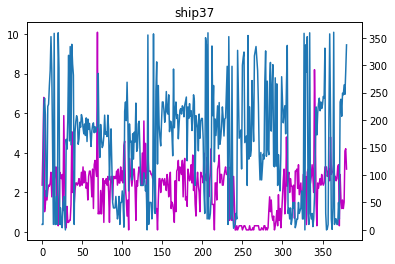

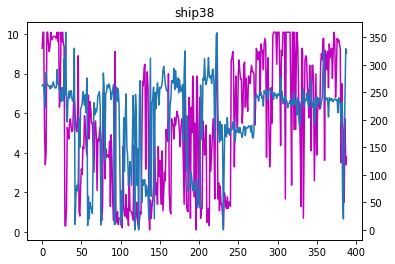

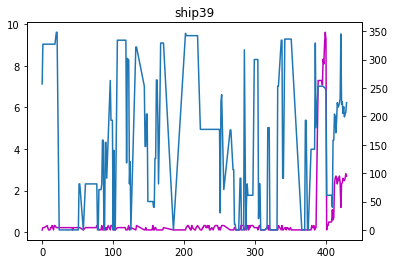

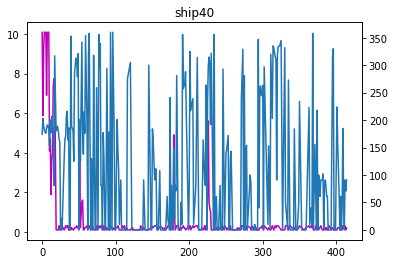

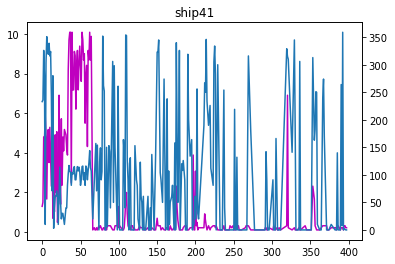

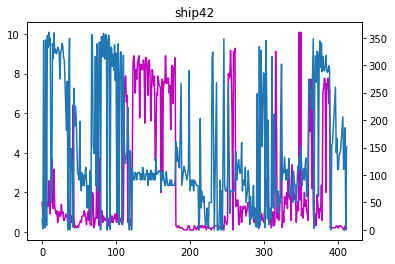

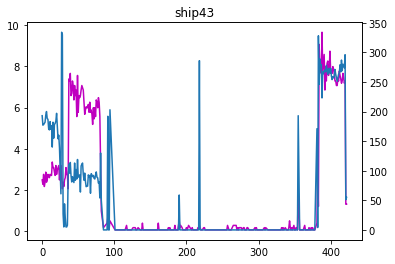

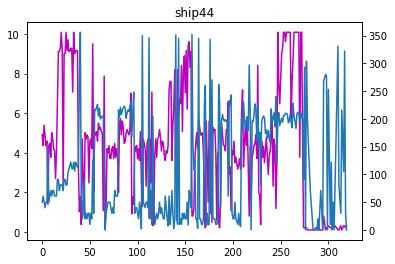

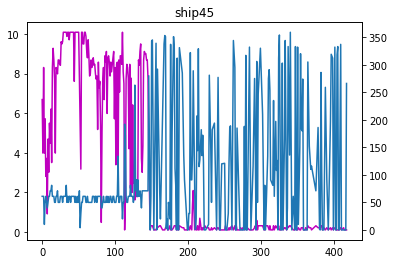

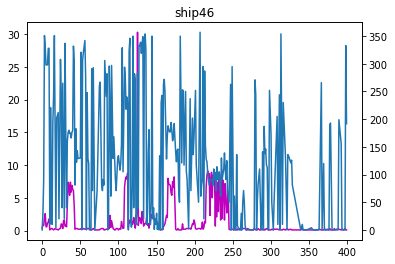

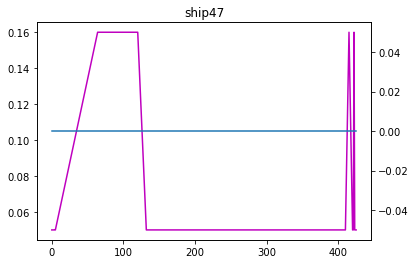

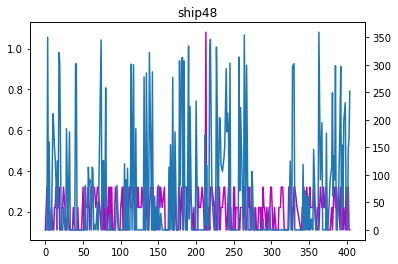

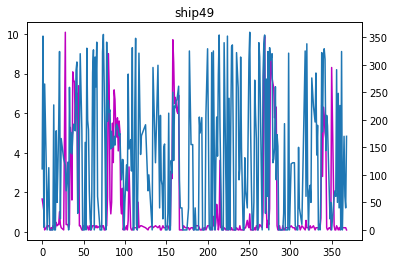

In [257]:

def v_d(data,i):
    fig,ax=plt.subplots(1,1)
    ax.plot(data['v'],'m')
    ax.set_title("ship"+str(i))
    axl=ax.twinx()
    axl.plot(data['d'])
    fig.show()
    
    
for i in range(50):
    t=data[data['ship']==i]
    v_d(t,i)

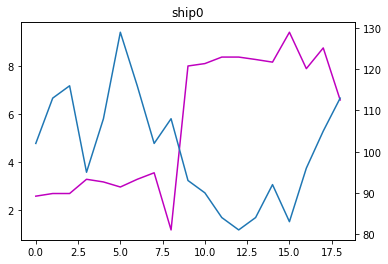

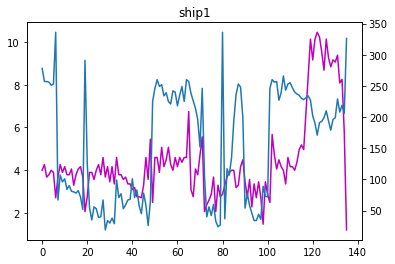

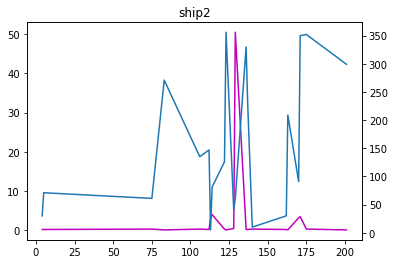

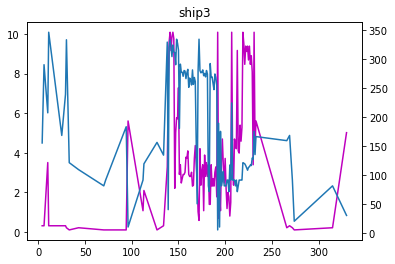

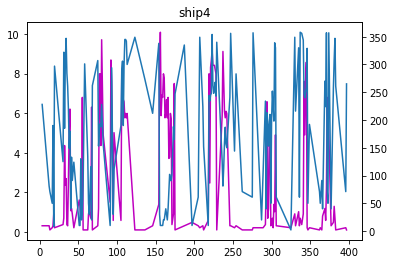

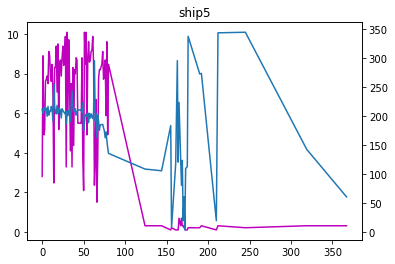

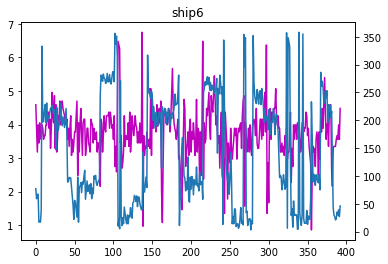

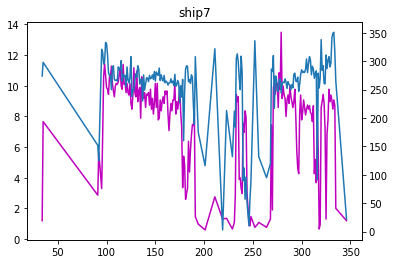

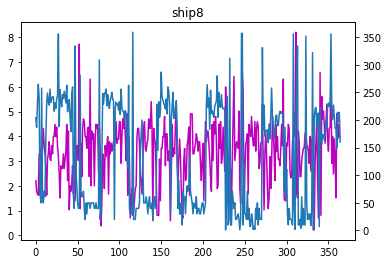

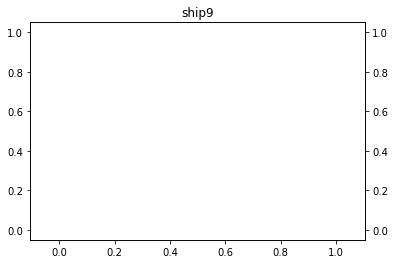

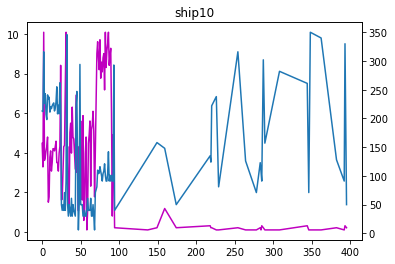

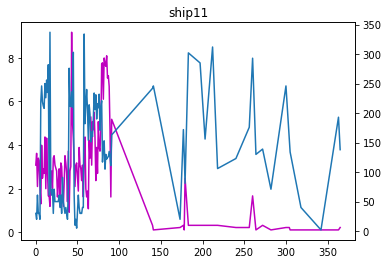

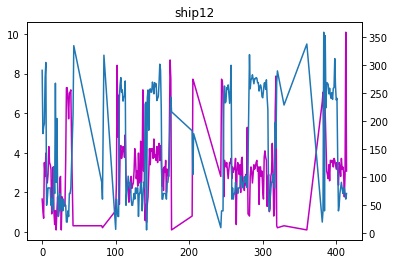

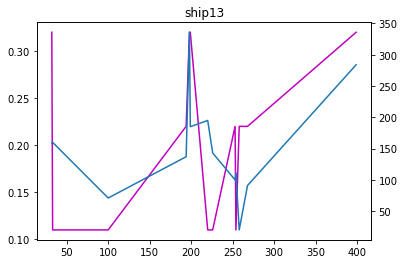

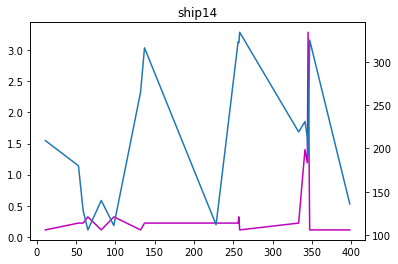

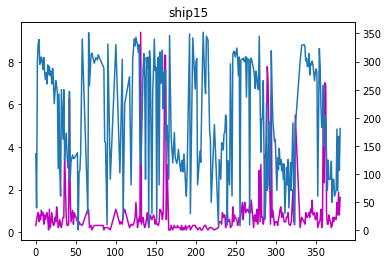

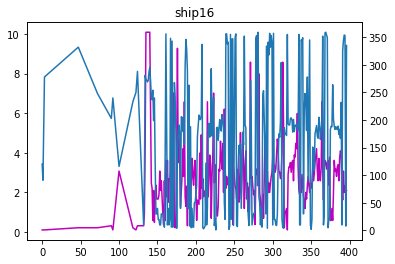

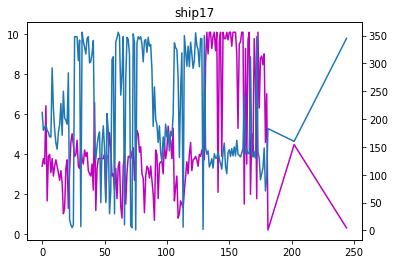

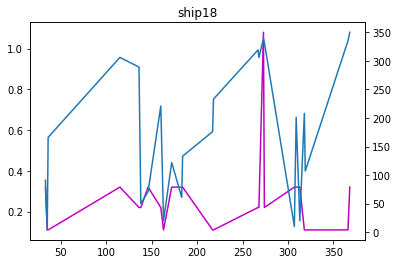

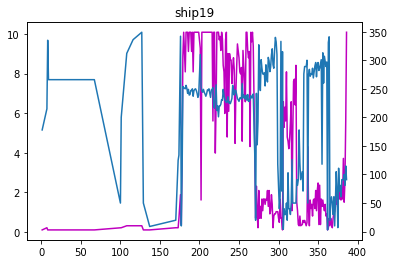

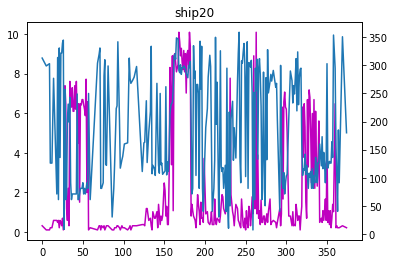

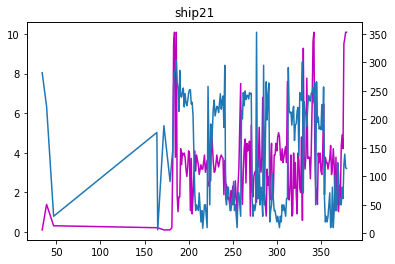

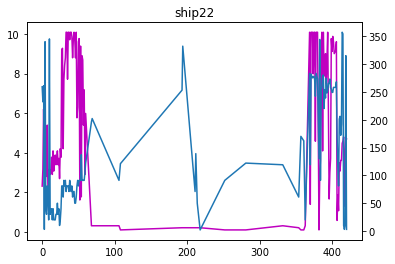

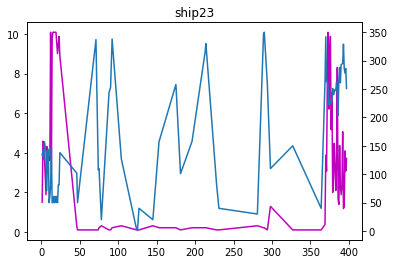

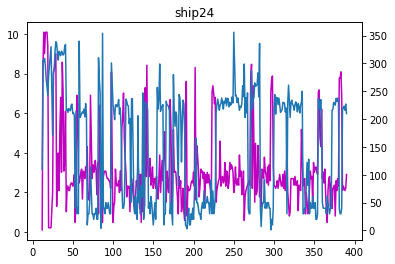

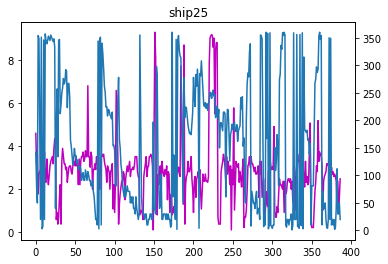

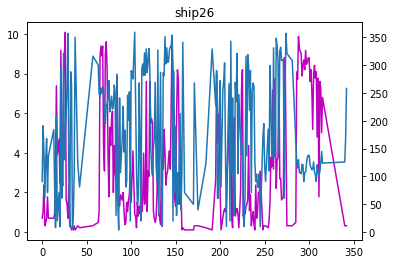

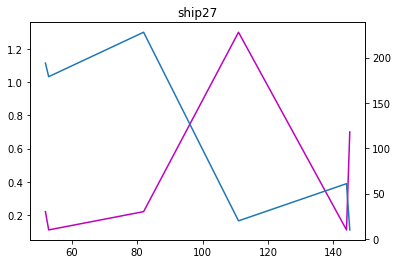

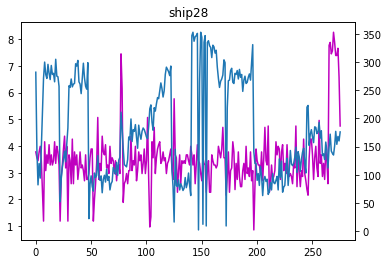

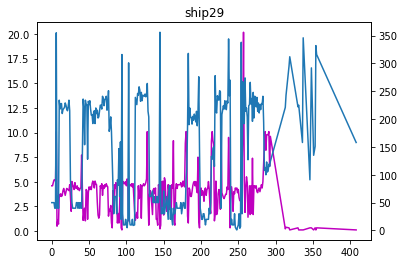

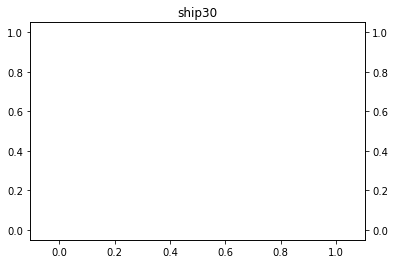

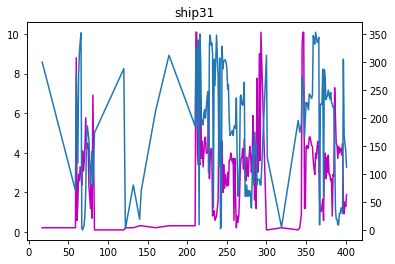

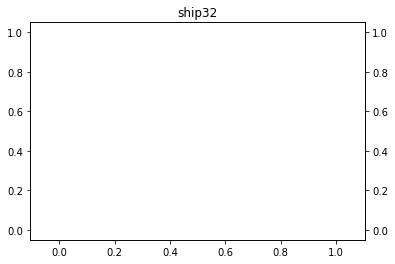

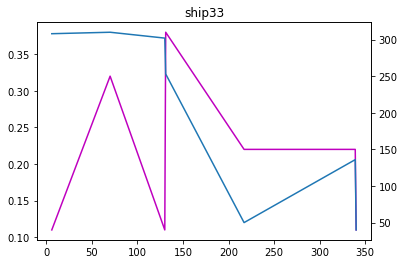

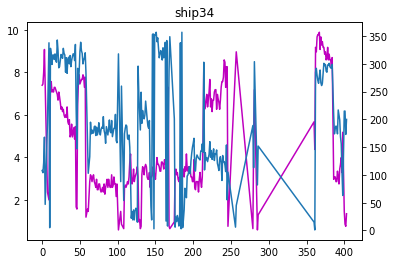

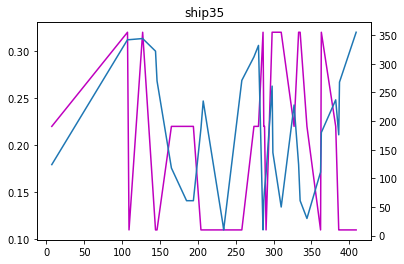

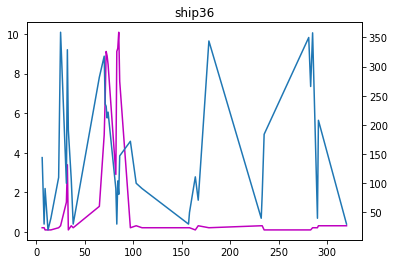

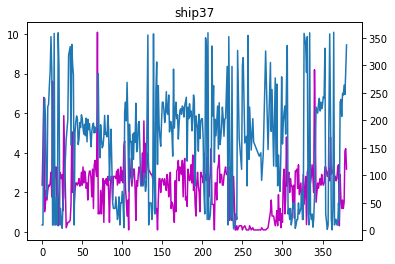

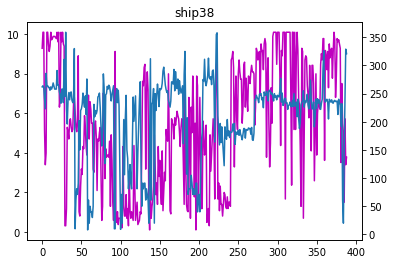

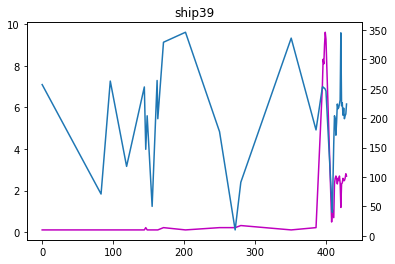

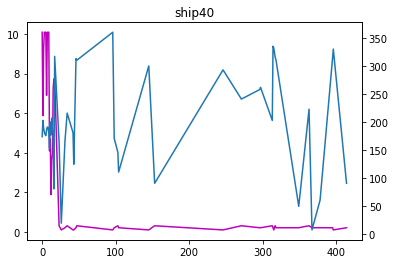

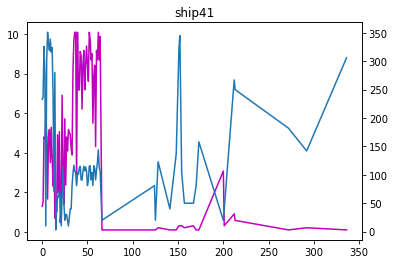

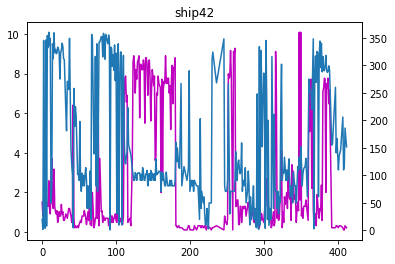

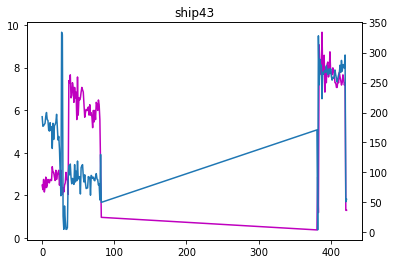

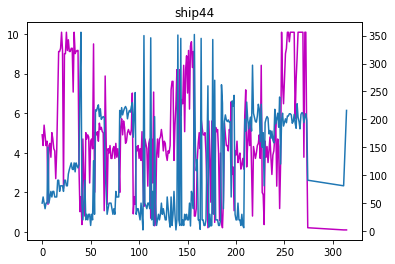

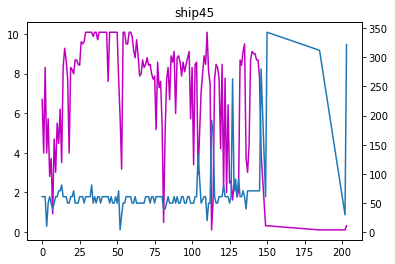

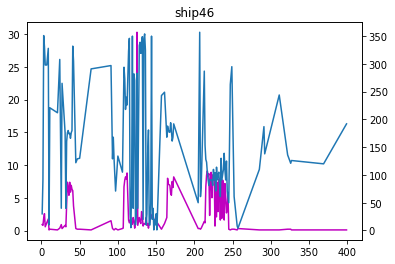

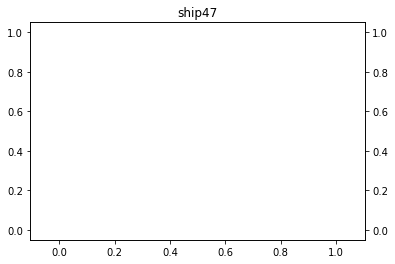

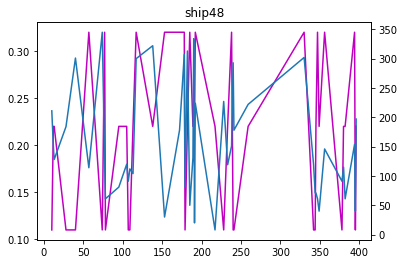

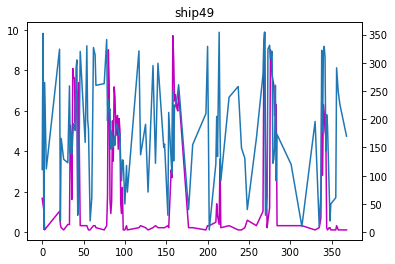

In [96]:

def v_d(data,i):
    fig,ax=plt.subplots(1,1)
    ax.plot(data['v'],'m')
    ax.set_title("ship"+str(i))
    axl=ax.twinx()
    axl.plot(data['d'])
    fig.show()
    
    
for i in range(50):
    t=tuo_test[tuo_test['ship']==i]
    v_d(t,i)

In [50]:
train[train['ship']==997]

ship             x             y     v    d           time type  \
0     997  6.093432e+06  5.120416e+06  0.32  318  1123 23:50:00   刺网   
1     997  6.093432e+06  5.120416e+06  0.22    0  1123 23:39:59   刺网   
2     997  6.093432e+06  5.120416e+06  0.22  284  1123 23:29:59   刺网   
3     997  6.093432e+06  5.120416e+06  0.00    0  1123 23:19:58   刺网   
4     997  6.093432e+06  5.120416e+06  0.00  261  1123 23:09:57   刺网   
5     997  6.093432e+06  5.120416e+06  0.11  110  1123 22:59:56   刺网   
6     997  6.093432e+06  5.120416e+06  0.00   81  1123 22:49:57   刺网   
7     997  6.093432e+06  5.120416e+06  0.22   61  1123 22:39:56   刺网   
8     997  6.093432e+06  5.120416e+06  0.00    0  1123 22:29:56   刺网   
9     997  6.093432e+06  5.120416e+06  0.32  310  1123 22:19:55   刺网   
10    997  6.093432e+06  5.120416e+06  0.22    0  1123 22:09:54   刺网   
11    997  6.093529e+06  5.120195e+06  0.00    0  1123 22:00:09   刺网   
12    997  6.093432e+06  5.120416e+06  0.22    0  1123 21:49:53   刺网   
13    997  6.093432e+06  5.120416e+06  0.32  347  1123 21:39:52   刺网   
14    997  6.093432e+06  5.120416e+06  0.32  288  1123 21:29:52   刺网   
15    997  6.093432e+06  5.120416e+06  0.32    0  1123 21:19:51   刺网   
16    997  6.093432e+06  5.120416e+06  0.11  320  1123 21:09:48   刺网   
17    997  6.093432e+06  5.120416e+06  0.92  323  1123 20:59:48   刺网   
18    997  6.093432e+06  5.120416e+06  2.00  311  1123 20:49:48   刺网   
19    997  6.093432e+06  5.120416e+06  0.22  315  1123 20:39:46   刺网   
20    997  6.093432e+06  5.120416e+06  0.22    0  1123 20:29:47   刺网   
21    997  6.093432e+06  5.120416e+06  0.81   10  1123 20:19:45   刺网   
22    997  6.093432e+06  5.120416e+06  0.00  116  1123 20:09:44   刺网   
23    997  6.093432e+06  5.120416e+06  0.00    0  1123 19:59:54   刺网   
24    997  6.093432e+06  5.120416e+06  0.22    0  1123 19:39:43   刺网   
25    997  6.093432e+06  5.120416e+06  0.00    0  1123 19:29:43   刺网   
26    997  6.093432e+06  5.120416e+06  0.11    0  1123 19:19:41   刺网   
27    997  6.093432e+06  5.120416e+06  0.00  200  1123 19:09:41   刺网   
28    997  6.093432e+06  5.120416e+06  0.22  132  1123 18:59:44   刺网   
29    997  6.093432e+06  5.120416e+06  0.32   81  1123 18:49:43   刺网   
30    997  6.093432e+06  5.120416e+06  0.32   71  1123 18:39:42   刺网   
31    997  6.093432e+06  5.120416e+06  0.32   71  1123 18:29:40   刺网   
32    997  6.093432e+06  5.120416e+06  0.32  131  1123 18:19:38   刺网   
33    997  6.093432e+06  5.120416e+06  0.22   10  1123 18:09:40   刺网   
34    997  6.093432e+06  5.120416e+06  0.32    0  1123 17:59:59   刺网   
35    997  6.093432e+06  5.120416e+06  0.32   50  1123 17:39:36   刺网   
36    997  6.093432e+06  5.120416e+06  0.32   81  1123 17:29:35   刺网   
37    997  6.093432e+06  5.120416e+06  0.11    0  1123 17:19:32   刺网   
38    997  6.093432e+06  5.120416e+06  0.11    0  1123 16:59:37   刺网   
39    997  6.093432e+06  5.120416e+06  0.00    0  1123 16:49:31   刺网   
40    997  6.093432e+06  5.120416e+06  0.00    0  1123 16:39:33   刺网   
41    997  6.093432e+06  5.120416e+06  0.00    0  1123 16:29:32   刺网   
42    997  6.093432e+06  5.120416e+06  0.11    0  1123 16:19:31   刺网   
43    997  6.093432e+06  5.120416e+06  0.00  217  1123 16:09:31   刺网   
44    997  6.093432e+06  5.120416e+06  0.11  277  1123 15:59:30   刺网   
45    997  6.093432e+06  5.120416e+06  0.32    0  1123 15:49:29   刺网   
46    997  6.093432e+06  5.120416e+06  0.32   10  1123 15:39:29   刺网   
47    997  6.093432e+06  5.120416e+06  0.00    0  1123 15:29:26   刺网   
48    997  6.093432e+06  5.120416e+06  0.00    0  1123 15:19:27   刺网   
49    997  6.093432e+06  5.120416e+06  0.00  228  1123 15:09:24   刺网   
50    997  6.093432e+06  5.120416e+06  0.32  187  1123 14:59:27   刺网   
51    997  6.093432e+06  5.120416e+06  0.32  169  1123 14:49:24   刺网   
52    997  6.093432e+06  5.120416e+06  0.00    0  1123 14:39:39   刺网   
53    997  6.093432e+06  5.120416e+06  0.32  279  1123 14:29:23   刺网   
54    997  6.093432e+06  5.120416e+06  0.32  

In [39]:
def show_path(type_name):
    ids = train[train['type']==type_name]['ship'].unique()
    ids = [ids[np.random.randint(len(ids))] for x in range(10)]
    t = train[train['ship'].isin(ids)]

    f, ax = plt.subplots(5,2, figsize=(8,20))
    for index, cur_id in enumerate(ids):
        cur = t[t['ship']==cur_id]
        i = index//2
        j = index % 2
        ax[i,j].plot(cur['x'], cur['y'])
#         if i==0 and j==0:
        ax[i,j].set_title(cur_id)

In [50]:
train[train['ship']==2963]

ship             x             y     v  d           time type
0    2963  6.315982e+06  5.291346e+06  0.00  0  1120 23:57:26   围网
1    2963  6.315982e+06  5.291346e+06  0.00  0  1120 23:47:26   围网
2    2963  6.315982e+06  5.291346e+06  0.00  0  1120 23:37:26   围网
3    2963  6.315982e+06  5.291346e+06  0.00  0  1120 23:27:26   围网
4    2963  6.315982e+06  5.291346e+06  0.00  0  1120 23:17:26   围网
5    2963  6.315982e+06  5.291346e+06  0.00  0  1120 23:07:26   围网
6    2963  6.315982e+06  5.291346e+06  0.00  0  1120 22:57:26   围网
7    2963  6.315982e+06  5.291346e+06  0.00  0  1120 22:47:26   围网
8    2963  6.315982e+06  5.291346e+06  0.00  0  1120 22:37:26   围网
9    2963  6.315982e+06  5.291346e+06  0.00  0  1120 22:27:26   围网
10   2963  6.315982e+06  5.291346e+06  0.00  0  1120 22:17:26   围网
11   2963  6.315982e+06  5.291346e+06  0.00  0  1120 22:08:26   围网
12   2963  6.315982e+06  5.291346e+06  0.00  0  1120 21:57:27   围网
13   2963  6.315982e+06  5.291346e+06  0.00  0  1120 21:47:27   围网
14   2963  6.315982e+06  5.291346e+06  0.00  0  1120 21:37:27   围网
15   2963  6.315982e+06  5.291346e+06  0.00  0  1120 21:29:52   围网
16   2963  6.315982e+06  5.291346e+06  0.00  0  1120 21:07:27   围网
17   2963  6.315982e+06  5.291346e+06  0.00  0  1120 20:57:27   围网
18   2963  6.315982e+06  5.291346e+06  0.00  0  1120 20:47:28   围网
19   2963  6.315982e+06  5.291346e+06  0.00  0  1120 20:37:27   围网
20   2963  6.315982e+06  5.291346e+06  0.00  0  1120 20:27:27   围网
21   2963  6.315982e+06  5.291346e+06  0.00  0  1120 20:17:27   围网
22   2963  6.315982e+06  5.291346e+06  0.05  0  1120 20:08:27   围网
23   2963  6.315982e+06  5.291346e+06  0.00  0  1120 19:57:27   围网
24   2963  6.315982e+06  5.291346e+06  0.05  0  1120 19:47:27   围网
25   2963  6.315982e+06  5.291346e+06  0.05  0  1120 19:37:27   围网
26   2963  6.315982e+06  5.291346e+06  0.05  0  1120 19:27:28   围网
27   2963  6.315982e+06  5.291346e+06  0.27  0  1120 19:17:27   围网
28   2963  6.315982e+06  5.291346e+06  0.05  0  1120 19:07:27   围网
29   2963  6.315982e+06  5.291346e+06  0.05  0  1120 18:57:27   围网
..    ...           ...           ...   ... ..            ...  ...
397  2963  6.315982e+06  5.291346e+06  0.00  0  1118 04:57:42   围网
398  2963  6.315982e+06  5.291346e+06  0.00  0  1118 04:47:42   围网
399  2963  6.315982e+06  5.291346e+06  0.00  0  1118 04:37:41   围网
400  2963  6.315982e+06  5.291346e+06  0.00  0  1118 04:27:42   围网
401  2963  6.315982e+06  5.291346e+06  0.00  0  1118 04:17:42   围网
402  2963  6.315982e+06  5.291346e+06  0.00  0  1118 04:08:40   围网
403  2963  6.315982e+06  5.291346e+06  0.00  0  1118 03:57:41   围网
404  2963  6.315982e+06  5.291346e+06  0.00  0  1118 03:47:41   围网
405  2963  6.315982e+06  5.291346e+06  0.00  0  1118 03:37:42   围网
406  2963  6.315982e+06  5.291346e+06  0.00  0  1118 03:27:42   围网
407  2963  6.315982e+06  5.291346e+06  0.00  0  1118 03:17:42   围网
408  2963  6.315982e+06  5.291346e+06  0.00  0  1118 03:07:42   围网
409  2963  6.315982e+06  5.291346e+06  0.00  0  1118 02:57:42   围网
410  2963  6.315982e+06  5.291346e+06  0.00  0  1118 02:47:42   围网
411  2963  6.315982e+06  5.291346e+06  0.00  0  1118 02:37:42   围网
412  2963  6.315982e+06  5.291346e+06  0.00  0  1118 02:27:42   围网
413  2963  6.315982e+06  5.291346e+06  0.00  0  1118 02:17:42   围网
414  2963  6.315982e+06  5.291346e+06  0.00  0  1118 02:08:40   围网
415  2963  6.315982e+06  5.291346e+06  0.00  0  1118 01:57:42   围网
416  2963  6.315982e+06  5.291346e+06  0.00  0  1118 01:47:43   围网
417  2963  6.315982e+06  5.291346e+06  0.00  0  1118 01:37:43   围网
418  2963  6.315982e+06  5.291346e+06  0.00  0  1118 01:27:43   围网
419  2963  6.315982e+06  5.291346e+06  0.00  0  1118 01:17:43   围网
420  2963  6.315982e+06  5.291346e+06  0.00  0  1118 01:07:43   围网
421  2963  6.315982e+06  5.291346e+06  0.00  0  1118 00:57:43   围网
422  2963  6.315982e+06  5.291346e+06  0.00  0  1118 00:47:43   围网
423  2963  6.315982e+06  5.291346e+06  0.00  0  1118 00:37:43   围网
424  2963  6.315982e+06  5.291346e+06  0.00  0  1118

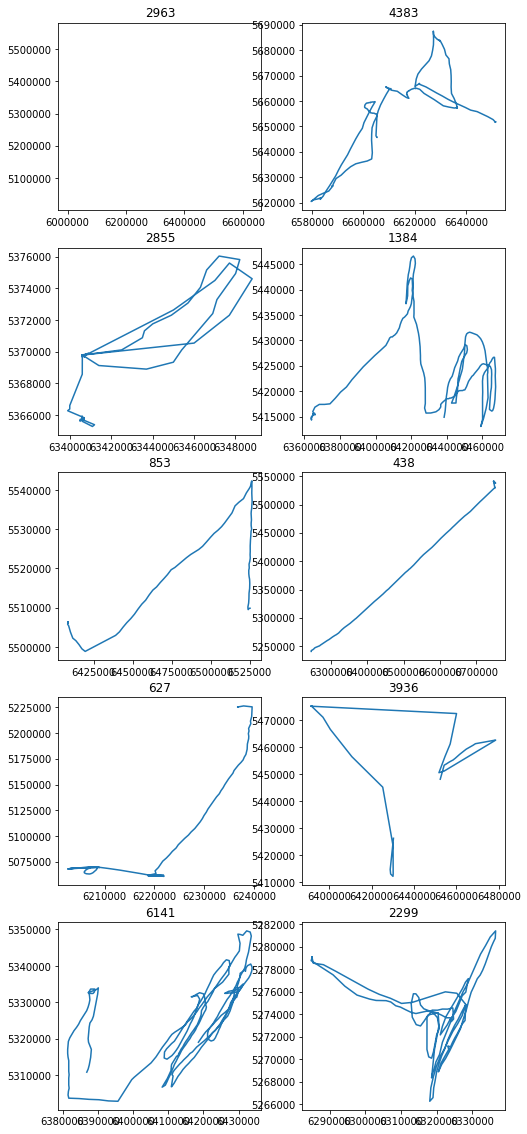

In [46]:
show_path('围网')

In [51]:
train[train['ship']==4022]

ship             x             y     v  d           time type
0    4022  6.102550e+06  5.112648e+06  0.00  0  1120 23:55:45   拖网
1    4022  6.102550e+06  5.112648e+06  0.00  0  1120 23:45:45   拖网
2    4022  6.102550e+06  5.112648e+06  0.00  0  1120 23:35:45   拖网
3    4022  6.102550e+06  5.112648e+06  0.00  0  1120 23:25:45   拖网
4    4022  6.102550e+06  5.112648e+06  0.00  0  1120 23:15:45   拖网
5    4022  6.102550e+06  5.112648e+06  0.00  0  1120 23:06:43   拖网
6    4022  6.102550e+06  5.112648e+06  0.00  0  1120 22:55:45   拖网
7    4022  6.102550e+06  5.112648e+06  0.00  0  1120 22:45:45   拖网
8    4022  6.102550e+06  5.112648e+06  0.00  0  1120 22:35:45   拖网
9    4022  6.102550e+06  5.112648e+06  0.00  0  1120 22:25:46   拖网
10   4022  6.102550e+06  5.112648e+06  0.00  0  1120 22:15:45   拖网
11   4022  6.102550e+06  5.112648e+06  0.00  0  1120 22:05:45   拖网
12   4022  6.102550e+06  5.112648e+06  0.00  0  1120 21:55:46   拖网
13   4022  6.102550e+06  5.112648e+06  0.00  0  1120 21:45:46   拖网
14   4022  6.102550e+06  5.112648e+06  0.00  0  1120 21:35:46   拖网
15   4022  6.102550e+06  5.112648e+06  0.00  0  1120 21:25:46   拖网
16   4022  6.102550e+06  5.112648e+06  0.00  0  1120 21:15:46   拖网
17   4022  6.102550e+06  5.112648e+06  0.00  0  1120 21:06:44   拖网
18   4022  6.102550e+06  5.112648e+06  0.05  0  1120 20:55:46   拖网
19   4022  6.102550e+06  5.112648e+06  0.00  0  1120 20:45:46   拖网
20   4022  6.102550e+06  5.112648e+06  0.00  0  1120 20:35:46   拖网
21   4022  6.102550e+06  5.112648e+06  0.00  0  1120 20:25:46   拖网
22   4022  6.102550e+06  5.112648e+06  0.00  0  1120 20:15:46   拖网
23   4022  6.102550e+06  5.112648e+06  0.00  0  1120 20:05:46   拖网
24   4022  6.102550e+06  5.112648e+06  0.00  0  1120 19:55:46   拖网
25   4022  6.102550e+06  5.112648e+06  0.00  0  1120 19:45:46   拖网
26   4022  6.102550e+06  5.112648e+06  0.00  0  1120 19:35:46   拖网
27   4022  6.102550e+06  5.112648e+06  0.00  0  1120 19:25:46   拖网
28   4022  6.102550e+06  5.112648e+06  0.00  0  1120 19:15:46   拖网
29   4022  6.102550e+06  5.112648e+06  0.05  0  1120 19:06:44   拖网
..    ...           ...           ...   ... ..            ...  ...
391  4022  6.102550e+06  5.112648e+06  0.16  0  1118 04:55:59   拖网
392  4022  6.102550e+06  5.112648e+06  0.00  0  1118 04:45:59   拖网
393  4022  6.102550e+06  5.112648e+06  0.00  0  1118 04:35:59   拖网
394  4022  6.102550e+06  5.112648e+06  0.00  0  1118 04:25:58   拖网
395  4022  6.102550e+06  5.112648e+06  0.05  0  1118 04:15:59   拖网
396  4022  6.102550e+06  5.112648e+06  0.00  0  1118 04:05:59   拖网
397  4022  6.102550e+06  5.112648e+06  0.00  0  1118 03:55:59   拖网
398  4022  6.102550e+06  5.112648e+06  0.00  0  1118 03:45:59   拖网
399  4022  6.102550e+06  5.112648e+06  0.00  0  1118 03:35:59   拖网
400  4022  6.102550e+06  5.112648e+06  0.00  0  1118 03:25:59   拖网
401  4022  6.102550e+06  5.112648e+06  0.00  0  1118 03:15:59   拖网
402  4022  6.102550e+06  5.112648e+06  0.00  0  1118 03:06:57   拖网
403  4022  6.102550e+06  5.112648e+06  0.00  0  1118 02:55:59   拖网
404  4022  6.102550e+06  5.112648e+06  0.00  0  1118 02:45:59   拖网
405  4022  6.102550e+06  5.112648e+06  0.00  0  1118 02:35:59   拖网
406  4022  6.102550e+06  5.112648e+06  0.00  0  1118 02:25:59   拖网
407  4022  6.102550e+06  5.112648e+06  0.05  0  1118 02:15:59   拖网
408  4022  6.102550e+06  5.112648e+06  0.00  0  1118 02:05:59   拖网
409  4022  6.102550e+06  5.112648e+06  0.00  0  1118 01:55:59   拖网
410  4022  6.102550e+06  5.112648e+06  0.05  0  1118 01:45:59   拖网
411  4022  6.102550e+06  5.112648e+06  0.00  0  1118 01:35:59   拖网
412  4022  6.102550e+06  5.112648e+06  0.00  0  1118 01:26:00   拖网
413  4022  6.102550e+06  5.112648e+06  0.00  0  1118 01:16:00   拖网
414  4022  6.102550e+06  5.112648e+06  0.00  0  1118 01:06:58   拖网
415  4022  6.102550e+06  5.112648e+06  0.05  0  1118 00:56:00   拖网
416  4022  6.102550e+06  5.112648e+06  0.05  0  1118 00:46:00   拖网
417  4022  6.102550e+06  5.112648e+06  0.00  0  1118 00:36:00   拖网
418  4022  6.102550e+06  5.112648e+06  0.00  0  1118

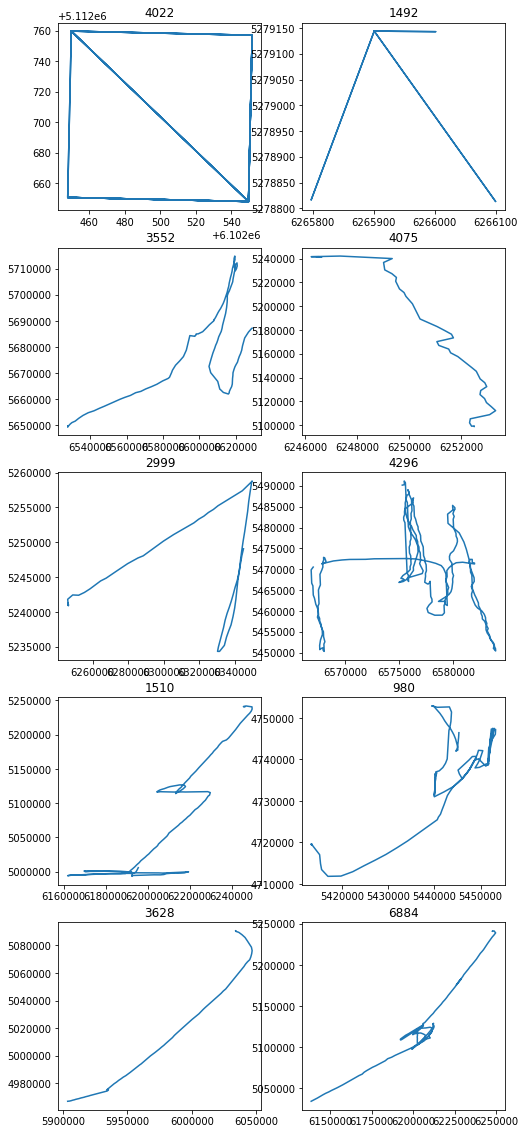

In [47]:

show_path('拖网')

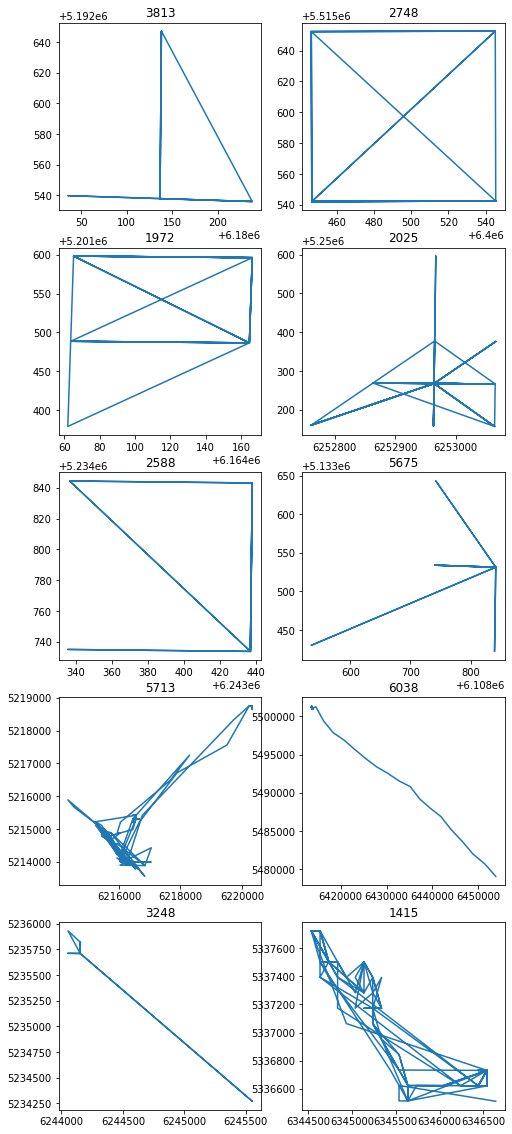

In [48]:
show_path('刺网')

In [49]:
train[train['ship']==1415]

ship             x             y     v    d           time type
0    1415  6.346640e+06  5.336511e+06  0.22  102  1110 11:54:35   刺网
1    1415  6.346640e+06  5.336511e+06  0.11    0  1110 11:44:35   刺网
2    1415  6.346640e+06  5.336511e+06  0.11    0  1110 11:34:35   刺网
3    1415  6.345538e+06  5.336624e+06  2.70    5  1110 11:24:33   刺网
4    1415  6.345538e+06  5.336514e+06  0.49    0  1110 11:14:32   刺网
5    1415  6.345538e+06  5.336514e+06  0.81   50  1110 11:04:57   刺网
6    1415  6.345638e+06  5.336514e+06  1.51    1  1110 10:44:28   刺网
7    1415  6.345438e+06  5.336734e+06  7.50  135  1110 10:34:32   刺网
8    1415  6.344638e+06  5.337504e+06  0.49  222  1110 10:24:31   刺网
9    1415  6.344738e+06  5.337504e+06  0.81   81  1110 10:14:47   刺网
10   1415  6.344638e+06  5.337504e+06  0.38   40  1110 10:04:29   刺网
11   1415  6.344638e+06  5.337394e+06  2.00  321  1110 09:54:46   刺网
12   1415  6.345239e+06  5.337173e+06  0.22  323  1110 09:44:25   刺网
13   1415  6.345138e+06  5.337174e+06  0.11  302  1110 09:34:25   刺网
14   1415  6.345138e+06  5.337174e+06  0.11  302  1110 09:34:24   刺网
15   1415  6.345239e+06  5.337173e+06  0.32  167  1110 09:24:27   刺网
16   1415  6.346440e+06  5.336622e+06  0.22  276  1110 09:14:25   刺网
17   1415  6.346540e+06  5.336621e+06  0.22  311  1110 09:04:25   刺网
18   1415  6.346540e+06  5.336621e+06  0.32    0  1110 08:54:23   刺网
19   1415  6.346540e+06  5.336621e+06  0.32  283  1110 08:44:21   刺网
20   1415  6.346540e+06  5.336621e+06  0.11   10  1110 08:34:21   刺网
21   1415  6.346540e+06  5.336621e+06  2.59  119  1110 08:24:22   刺网
22   1415  6.346540e+06  5.336621e+06  0.11  300  1110 08:14:21   刺网
23   1415  6.346540e+06  5.336621e+06  0.00   30  1110 08:04:18   刺网
24   1415  6.346540e+06  5.336621e+06  0.22  268  1110 07:54:19   刺网
25   1415  6.346540e+06  5.336621e+06  0.32    4  1110 07:44:20   刺网
26   1415  6.346540e+06  5.336621e+06  0.32  234  1110 07:34:17   刺网
27   1415  6.346540e+06  5.336621e+06  0.00  308  1110 07:24:17   刺网
28   1415  6.346540e+06  5.336621e+06  0.11  202  1110 07:14:17   刺网
29   1415  6.346540e+06  5.336621e+06  0.22    0  1110 07:04:17   刺网
..    ...           ...           ...   ...  ...            ...  ...
371  1415  6.346541e+06  5.336731e+06  0.00    0  1107 17:50:08   刺网
372  1415  6.346541e+06  5.336731e+06  0.22  313  1107 17:40:27   刺网
373  1415  6.346541e+06  5.336731e+06  0.32    0  1107 17:20:06   刺网
374  1415  6.346541e+06  5.336731e+06  0.22    0  1107 17:10:05   刺网
375  1415  6.346541e+06  5.336731e+06  0.22  189  1107 17:00:05   刺网
376  1415  6.346541e+06  5.336731e+06  0.32    0  1107 16:49:59   刺网
377  1415  6.346541e+06  5.336731e+06  0.22   91  1107 16:40:11   刺网
378  1415  6.346541e+06  5.336731e+06  0.00  306  1107 16:30:05   刺网
379  1415  6.346541e+06  5.336731e+06  0.00  297  1107 16:20:04   刺网
380  1415  6.346541e+06  5.336731e+06  0.11  296  1107 16:10:01   刺网
381  1415  6.346440e+06  5.336731e+06  0.00  292  1107 16:00:01   刺网
382  1415  6.346440e+06  5.336731e+06  0.32    0  1107 15:49:59   刺网
383  1415  6.346541e+06  5.336731e+06  0.22    0  1107 15:39:54   刺网
384  1415  6.346440e+06  5.336731e+06  0.11    0  1107 15:19:57   刺网
385  1415  6.346440e+06  5.336731e+06  0.11    0  1107 15:10:02   刺网
386  1415  6.346440e+06  5.336731e+06  0.00   61  1107 14:49:55   刺网
387  1415  6.346541e+06  5.336731e+06  0.11  300  1107 14:39:46   刺网
388  1415  6.346541e+06  5.336731e+06  0.00  111  1107 14:29:53   刺网
389  1415  6.346541e+06  5.336731e+06  0.11   71  1107 14:19:51   刺网
390  1415  6.346541e+06  5.336731e+06  0.32  254  1107 14:09:51   刺网
391  1415  6.346541e+06  5.336731e+06  0.11    0  1107 14:00:02   刺网
392  1415  6.346541e+06  5.336731e+06  0.32    0  1107 13:39:49   刺网
393  1415  6.346541e+06  5.336731e+06  0.11  349  1107 13:29:49   刺网
394  1415  6.346541e+06  5.336731e+06  0.32  238  1107 13:09:46   刺网
395  1415  6.346541e+06  5.336731e+06  0.11  295  1107 12:59:45   刺网
396  1415  6.346541e+06  5.336731e+06  0.32    0  1107 12:49:44   刺网
397